# 0. Importing libraries

In [55]:
import pandas as pd
import re
import nltk
from nltk.corpus import wordnet
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from nltk.sentiment import SentimentIntensityAnalyzer
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.attrs import ORTH, NORM
import nest_asyncio
import spacy
from nltk import word_tokenize
from word_piece_tokenizer import WordPieceTokenizer
from pywaffle import Waffle

nest_asyncio.apply()

In [3]:
nltk.download("wordnet")
nltk.download("punkt")
nltk.downloader.download("vader_lexicon")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Benya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Benya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Benya\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# A. Data Preparation

In [33]:
data = pd.read_csv("spooky.csv")
data.head(10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


# B. Text Cleaning

## 1. Handling reapeted characters

In [61]:
# Compile regular expression pattern to match repeating characters within words
repeating_char_pattern = re.compile(r"(\w*)(\w)\2(\w*)")

# Replacement pattern to remove repeated characters
replacement_pattern = r"\1\2\3"


def remove_repeating_chars(word):
    # Check if the word exists in WordNet
    if nltk.corpus.wordnet.synsets(word):
        return word

    # Apply regular expression substitution to remove repeating characters
    replaced_word = repeating_char_pattern.sub(replacement_pattern, word)

    # If replacements were made, recursively call the function
    if replaced_word != word:
        return remove_repeating_chars(replaced_word)
    else:
        return replaced_word


def clean_text(text):
    # Split the input text into words
    words = text.split()
    cleaned_words = []

    # Process each word to remove repeating characters
    for word in words:
        cleaned_words.append(remove_repeating_chars(word))

    # Join the cleaned words back into a single string
    cleaned_text = " ".join(cleaned_words)

    return cleaned_text

In [62]:
clean_text("coool and Coooooool niice broo!")

'cool and Cool nice bro!'

In [63]:
# apply the function to the text column
data["text"] = data["text"].apply(clean_text)

In [64]:
data.dropna(inplace=True)

## 2. Managing homoglyphs


In [65]:
homoglyph_map = {
    "a": [
        "а",
        "ɑ",
        "α",
        "ӑ",
        "ȧ",
        "ǎ",
        "ạ",
        "ả",
        "a̤",
        "ḁ",
        "a̧",
        "ä",
        "å",
        "æ",
        "a̰",
        "a̱",
        "a̷",
        "а̰",
        "а̱",
        "а̷",
    ],
    "b": ["ƀ", "ƃ", "ɓ", "ƅ", "Ƅ", "ƅ", "β", "b̤", "b̥", "ḃ", "ḅ", "ḇ"],
    "c": ["ϲ", "с", "ç", "ć", "ĉ", "ċ", "č", "ĉ", "ç", "c̭"],
    "d": ["ԁ", "ď", "ḋ", "ḍ", "ḏ", "ḑ", "ḓ", "ď", "đ", "ƌ", "Ƌ", "ƌ", "ɖ"],
    "e": [
        "е",
        "є",
        "ё",
        "ē",
        "ĕ",
        "ė",
        "ę",
        "ě",
        "ẹ",
        "ẻ",
        "è",
        "é",
        "ê",
        "ë",
        "ɇ",
        "ɛ",
        "ḛ",
        "e̱",
        "e̷",
        "э",
        "ɘ",
        "ɜ",
    ],
    "f": ["ƒ", "f̤", "f̥", "ḟ"],
    "g": ["ɡ", "ɠ", "ğ", "ǧ", "ģ", "ĝ", "g̈", "ğ", "ģ", "ġ"],
    "h": ["һ", "հ", "ɦ", "ħ", "ȟ", "ḣ", "ḥ", "ḧ", "ḩ", "ḫ", "ḧ", "h̄", "ḥ", "ẖ", "h̲"],
    "i": ["і", "ї", "1", "|", "!", "í", "ì", "ï", "ī", "ĭ", "į", "ỉ", "ị", "ɨ", "ɪ"],
    "j": ["ј", "ʝ", "ĵ", "ǰ", "ɉ", "ĵ", "ǰ", "j̇"],
    "k": ["κ", "к", "ƙ", "ķ", "ǩ", "ḳ", "ḵ", "k̄", "k̆", "k̇", "k̂"],
    "l": ["1", "|", "!", "1", "ɫ", "ɬ", "ɭ", "ĺ", "ļ", "ľ", "ŀ", "ḷ", "ḹ", "ḻ", "ḽ"],
    "m": ["ʍ", "ɯ", "ɰ", "ɱ", "м", "ṁ", "ṃ", "ṅ", "ṇ", "ṉ", "ṋ", "ṍ", "ṏ", "m̂"],
    "n": ["п", "ɴ", "ñ", "ń", "ņ", "ň", "ŉ", "ŋ", "n̂", "n̈", "ň", "n̄", "ṇ", "ṉ", "n̲"],
    "o": [
        "ο",
        "о",
        "0",
        "ȯ",
        "ọ",
        "ỏ",
        "ò",
        "ó",
        "ô",
        "õ",
        "ö",
        "ø",
        "ő",
        "ǒ",
        "ȍ",
        "ȫ",
        "ȭ",
        "ȯ",
        "ȱ",
        "o̤",
        "o̥",
        "o̧",
        "ö",
        "ơ",
        "ɵ",
    ],
    "p": ["ρ", "р", "ƥ", "ṕ", "ṗ", "p̤", "p̥"],
    "q": ["զ", "ʠ", "ɋ", "q̈", "q̧", "q̇", "q̣", "q̱"],
    "r": ["г", "ɾ", "ɼ", "ɽ", "ɾ", "ɿ", "ŕ", "ŗ", "ř", "ȑ", "ȓ", "ṙ", "ṛ", "ṝ", "ṟ"],
    "s": ["ѕ", "ѕ", "$", "ʂ", "ś", "ŝ", "ş", "š", "ș", "ŝ", "s̈", "ş", "ṡ", "ṣ"],
    "t": ["т", "τ", "ť", "ţ", "ț", "t̂", "ẗ", "ť", "ṫ", "ṭ"],
    "u": [
        "υ",
        "ս",
        "ʋ",
        "ư",
        "ǔ",
        "ǖ",
        "ǘ",
        "ǚ",
        "ǜ",
        "ụ",
        "ủ",
        "ứ",
        "ừ",
        "ử",
        "ữ",
        "ự",
        "ṳ",
        "u̥",
        "u̧",
        "ü",
    ],
    "v": ["ν", "ѵ", "v̇", "ṽ", "ṿ", "v̤", "v̥", "v̈", "v̄", "v̱", "v̲"],
    "w": [
        "ա",
        "ʍ",
        "ω",
        "ω",
        "ώ",
        "ŵ",
        "ẁ",
        "ẃ",
        "ẅ",
        "ẇ",
        "ẉ",
        "ẘ",
        "ŵ",
        "ẅ",
        "w̄",
        "w̆",
        "ẇ",
        "ẅ",
        "ẉ",
    ],
    "x": ["×", "х", "ẍ", "x̌"],
    "y": ["у", "γ", "ý", "ỳ", "ÿ", "ȳ", "ÿ", "ỵ", "ỷ", "ỹ", "ƴ", "ŷ", "ÿ", "y̱", "y̲"],
    "z": ["ʐ", "z", "ž", "ż", "ẑ", "ẓ", "ẕ"],
}

In [66]:
def manage_homoglyphs(text, homoglyph_map):
    cleaned_text = []
    for char in text:
        for base_char, homoglyphs in homoglyph_map.items():
            if char in homoglyphs:
                cleaned_text.append(base_char)
                break
        else:
            cleaned_text.append(char)
    return "".join(cleaned_text)


# Test the function
original_text = "$tupide"
converted_text = manage_homoglyphs(original_text, homoglyph_map)
print(converted_text)  # Output: "stupide"

stupide


In [67]:
def normalaize_unicode_chars(text):
  return unicodedata.normalize('NFKD', text)

In [68]:
# apply the function to the text column
data["text"] = data["text"].apply(lambda x: manage_homoglyphs(x, homoglyph_map))

In [69]:
data["text"] = data["text"].apply(normalaize_unicode_chars)

## 3. Transform special entries

In [70]:
import re


def transform_urls(text):
    return re.sub(r"\b(?:https?|ftp)://\S+", "[URL]", text)


def transform_emails(text):
    return re.sub(
        r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "[EMAIL]", text
    )


def transform_html_tags(text):
    return re.sub(r"<[^>]*>", "[HTML]", text)


# Test the functions
original_text = "Visit my website at https://www.example.com. You can also email me at user@example.com. <div>Hello, world!</div>"

transformed_text = transform_urls(original_text)
print(transformed_text)

transformed_text = transform_emails(transformed_text)
print(transformed_text)

transformed_text = transform_html_tags(transformed_text)
print(transformed_text)

Visit my website at [URL] You can also email me at user@example.com. <div>Hello, world!</div>
Visit my website at [URL] You can also email me at [EMAIL]. <div>Hello, world!</div>
Visit my website at [URL] You can also email me at [EMAIL]. [HTML]Hello, world![HTML]


In [71]:
# apply the functions to the text column
data["text"] = data["text"].apply(transform_urls)
data["text"] = data["text"].apply(transform_emails)
data["text"] = data["text"].apply(transform_html_tags)


## 4. Convert all characters to lowercase.

In [72]:
# covert to lower case
data["text"] = data["text"].str.lower()
data["text"].head(10)

0    this proces however afforded means ascertainin...
1        it never occurred fumbling might mere mistake
2    in left hand gold snuff box capered hil cuttin...
3    how lovely spring as looked windsor terrace si...
4    finding nothing else even gold superintendent ...
5    a youth passed solitude best years spent gentl...
6    the astronomer perhaps point took refuge sugge...
7                      the surcingle hung ribands body
8    i knew could say without brought think atomies...
9    i confess neither structure languages code gov...
Name: text, dtype: object

## 5. Remove punctuation.

In [73]:
def remove_punctuation(text):
    tokens = word_tokenize(text)
    tokens_without_punctuation = [token for token in tokens if re.match(r'^\w+$', token)]
    clean_text = ' '.join(tokens_without_punctuation)
    return clean_text

text = "This is an example sentence! It contains punctuation."
remove_punctuation(text)


'This is an example sentence It contains punctuation'

In [74]:
# apply the function to the text column
data["text"] = data["text"].apply(remove_punctuation)
data["text"].head(10)

0    this proces however afforded means ascertainin...
1        it never occurred fumbling might mere mistake
2    in left hand gold snuff box capered hil cuttin...
3    how lovely spring as looked windsor terrace si...
4    finding nothing else even gold superintendent ...
5    a youth passed solitude best years spent gentl...
6    the astronomer perhaps point took refuge sugge...
7                      the surcingle hung ribands body
8    i knew could say without brought think atomies...
9    i confess neither structure languages code gov...
Name: text, dtype: object

## 6. Remove stop words.

In [75]:
# remove stop words
stop = stopwords.words("english")
data["text"] = data["text"].apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop)])
)
data["text"].head(10)

0    proces however afforded means ascertaining dim...
1           never occurred fumbling might mere mistake
2    left hand gold snuff box capered hil cutting m...
3    lovely spring looked windsor terrace sixteen f...
4    finding nothing else even gold superintendent ...
5    youth passed solitude best years spent gentle ...
6    astronomer perhaps point took refuge suggestio...
7                          surcingle hung ribands body
8    knew could say without brought think atomies t...
9    confess neither structure languages code gover...
Name: text, dtype: object

# C. Tokenization

## 1. Space based tokenization

In [76]:
# space based tokenization
data["space_tokenized_text"] = data["text"].apply(lambda x: word_tokenize(x))
data["space_tokenized_text"].head(10)

0    [proces, however, afforded, means, ascertainin...
1    [never, occurred, fumbling, might, mere, mistake]
2    [left, hand, gold, snuff, box, capered, hil, c...
3    [lovely, spring, looked, windsor, terrace, six...
4    [finding, nothing, else, even, gold, superinte...
5    [youth, passed, solitude, best, years, spent, ...
6    [astronomer, perhaps, point, took, refuge, sug...
7                     [surcingle, hung, ribands, body]
8    [knew, could, say, without, brought, think, at...
9    [confess, neither, structure, languages, code,...
Name: space_tokenized_text, dtype: object

## 2. Rule based tokenization

In [77]:
tqdm.pandas()
# Tokenize each sentence using a rule-based tokenization algorithm.
rules = {
    "can't": [{ORTH: "ca", NORM: "can"}, {ORTH: "n't", NORM: "not"}],
    "don't": [{ORTH: "do"}, {ORTH: "n't", NORM: "not"}],
    "wanna": [{ORTH: "wan", NORM: "want"}, {ORTH: "na", NORM: "to"}],
    "gonna": [{ORTH: "gon", NORM: "going"}, {ORTH: "na", NORM: "to"}]
}


nlp = English()
tokenizer = Tokenizer(nlp.vocab, rules=rules)

for key, rule in rules.items():
    tokenizer.add_special_case(key, rule)

# Tokenize the text
rule_vocab = []
rule_tokenized_text = data["text"].progress_apply(lambda x: rule_vocab.extend([t.norm_ for t in tokenizer(x)]))
rule_vocab = set(rule_vocab)
print(rule_vocab)

  0%|          | 0/19579 [00:00<?, ?it/s]

{'neber', 'help', 'sycamore', 'adornment', 'equalize', 'recommended', 'unidentifiable', 'dominate', 'die', 'refastened', 'traitor', 'duelo', 'reigned', 'debils', 'lineage', 'receptive', 'uniting', 'unmanned', 'disheartened', 'divesting', 'repinings', 'tekel', 'violets', 'commands', 'dreads', 'watchin', 'viii', 'eruptions', 'lark', 'spoleto', 'rusian', 'conjugal', 'hypotheses', 'unhand', 'setler', 'noting', 'exploding', 'fulgurite', 'terminer', 'reces', 'ignes', 'tailor', 'delicious', 'stars', 'combatendo', 'rummaging', 'reality', 'saying', 'auriculas', 'unwittingly', 'decanter', 'add', 'discusing', 'perpetual', 'thirtieth', 'blighted', 'abroad', 'aclivity', 'flying', 'acquaintances', 'falstaffian', 'novers', 'ruthless', 'crystal', 'plentifulness', 'crayons', 'qu', 'text', 'honor', 'counters', 'vessels', 'sagaciously', 'agin', 'transport', 'radio', 'acme', 'jewelry', 'hyacinths', 'dammed', 'mended', 'colourless', 'convenient', 'thousands', 'chagrin', 'strolling', 'astounding', 'remedied

## 3. Subword Tokenization

In [78]:
#Tokenize each sentence using a subword tokenization algorithm.
# Create a WordPiece tokenizer
word_piece_tokenizer = WordPieceTokenizer()
def wordpiece(text):
    ids = word_piece_tokenizer.tokenize(text)
    return word_piece_tokenizer.convert_ids_to_tokens(ids)

# Tokenize the text
subword_vocab = []
wordpiece_tokenized_text = data["text"].progress_apply(lambda x : subword_vocab.extend(wordpiece(x)))
subword_vocab = set(subword_vocab)



  0%|          | 0/19579 [00:00<?, ?it/s]

# D. Named Entity Recognition

In [79]:
nlp = spacy.load("en_core_web_sm")

def perform_ner(text):
    doc = nlp(text)
    
    print(f'The text : {text}')
    print(f'\nNamed Entities :\n')
    
    for i, ent in enumerate(doc.ents):
        print(f"NER {i} = (text={ent.text}, start_char={ent.start_char}, end_char={ent.end_char}, label={ent.label_})")

text_to_process = data["text"].iloc[100]
perform_ner(text_to_process)


The text : still appeared public together lived rof

Named Entities :



# E. Form Reduction

In [80]:
#Use lemmatization and stemming with NLTK.
stemmer = SnowballStemmer(language="english")
data["stemmed_text"] = data["text"].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
data["stemmed_text"].head(10)

0    proce howev afford mean ascertain dimens dunge...
1                  never occur fumbl might mere mistak
2    left hand gold snuff box caper hil cut manner ...
3    love spring look windsor terrac sixteen fertil...
4    find noth els even gold superintend abandon at...
5    youth pass solitud best year spent gentl femin...
6    astronom perhap point took refug suggest non l...
7                            surcingl hung riband bodi
8    knew could say without brought think atomi thu...
9    confess neither structur languag code govern p...
Name: stemmed_text, dtype: object

# F. Frequency Analysis

## 1. Count the number of sentences, for each author, where the word "Great" appears.

In [81]:
#frequency analysis
authorByText = data[["text","author"]].groupby(by="author").agg(' '.join)
cv = CountVectorizer().fit(authorByText["text"])
counts = cv.transform(authorByText["text"])
counted_text = pd.DataFrame(data=counts.toarray(),index=authorByText.index,columns=cv.get_feature_names_out())
counted_text["great"]

author
EAP    227
HPL    195
MWS     89
Name: great, dtype: int64

## 2. Use pywaffle to obtain a graph summarizing the number of occurrences of the word "great" per author.

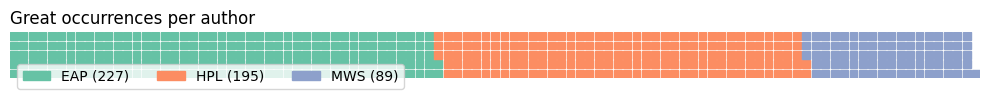

In [82]:
#Use pywaffle to obtain a graph summarizing the number of occurrences of the word "great" per author.
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=counted_text["great"],
    title={"label": "Great occurrences per author", "loc": "left"},
    labels=[f"{k} ({v})" for k, v in counted_text["great"].items()],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.4), "ncol": len(counted_text["great"])},
    figsize=(10, 5),
)

## 3. Repeat the analysis with the word "impossible".

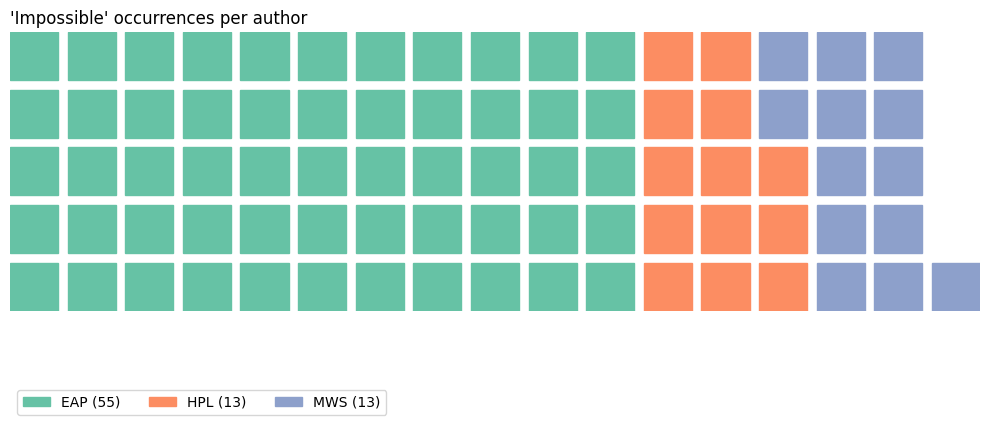

In [83]:
#Repeat the analysis with the word "impossible".
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=counted_text["impossible"],
    title={"label": "'Impossible' occurrences per author", "loc": "left"},
    labels=[f"{k} ({v})" for k, v in counted_text["impossible"].items()],
    legend={"loc": "lower left", "bbox_to_anchor": (0, -0.4), "ncol": len(counted_text["great"])},
    figsize=(10, 5),
)


## 4. Using the wordCloud function, create three word clouds to represent the most used words by each author.

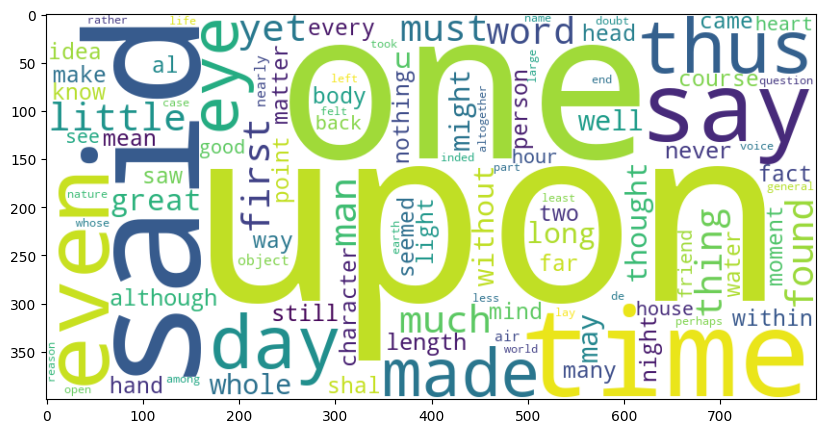

In [84]:
#Using the wordCloud function, create three word clouds to represent the most used words by each author.
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(authorByText["text"]["EAP"])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")


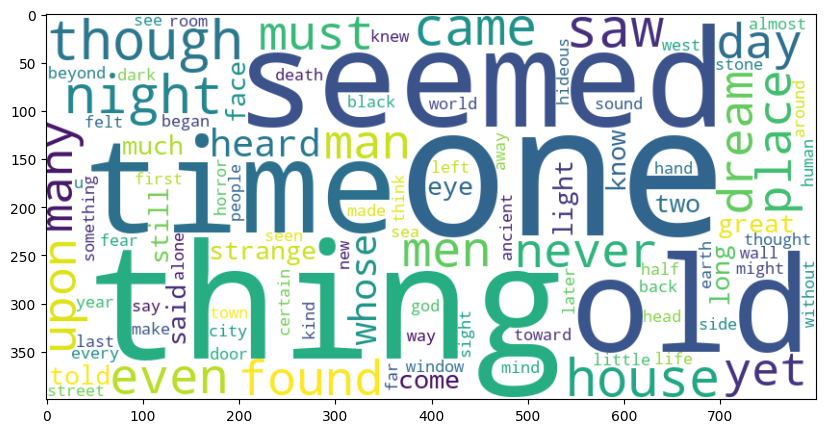

In [85]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(authorByText["text"]["HPL"])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")

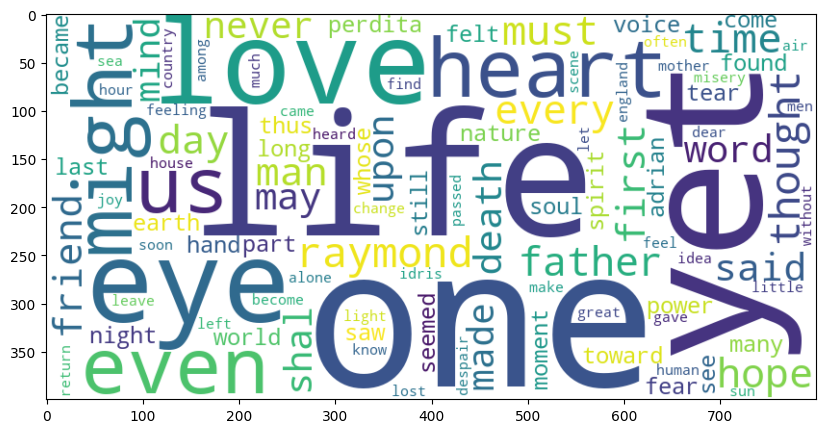

In [86]:
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(authorByText["text"]["MWS"])
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")

## 5. Using the wordCloud function, display the top 100 positive and negative words used by the authors.

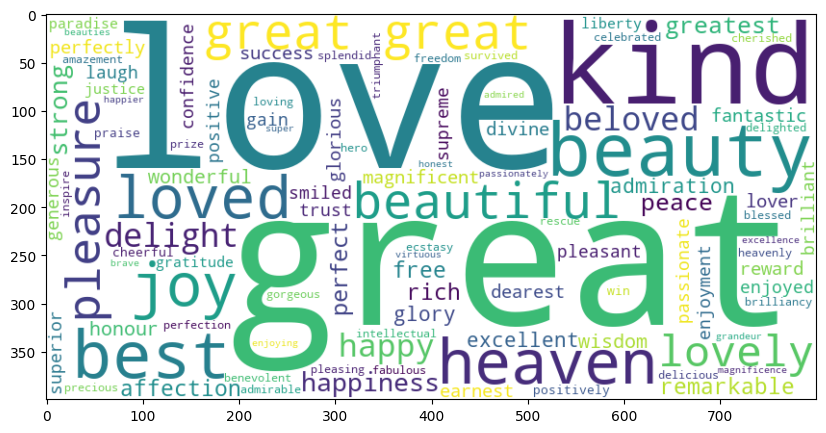

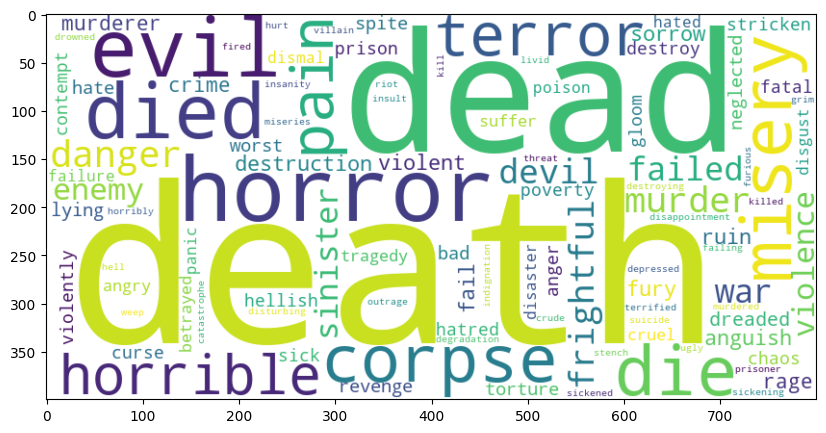

In [87]:
#Using the wordCloud function, display the top 100 positive and negative words used by the authors.
sid = SentimentIntensityAnalyzer()
positive_words = []
negative_words = []
for author in authorByText.index:
    for word in authorByText["text"][author].split():
        if sid.polarity_scores(word)["compound"] > 0.5:
            positive_words.append(word)
        elif sid.polarity_scores(word)["compound"] < -0.5:
            negative_words.append(word)

positive_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(" ".join(positive_words))
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation="bilinear")

negative_wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white").generate(" ".join(negative_words))
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation="bilinear")



# G. Exporting the Dataset

In [88]:
data.to_csv("spooky_cleaned.csv", index=False)